In [1]:
cd /orange/adamginsburg/jwst/brick/

/orange/adamginsburg/jwst/brick


In [2]:
basepath = '/orange/adamginsburg/jwst/brick/'

In [3]:
from astropy import coordinates

In [4]:
import numpy as np

In [5]:
from photutils import CircularAperture, EPSFBuilder, find_peaks, CircularAnnulus
from photutils.detection import DAOStarFinder, IRAFStarFinder
from photutils.psf import DAOGroup, IntegratedGaussianPRF, extract_stars, IterativelySubtractedPSFPhotometry, BasicPSFPhotometry

In [6]:
import warnings

In [7]:
import regions

In [8]:
from photutils.background import MMMBackground, MADStdBackgroundRMS
from astropy.modeling.fitting import LevMarLSQFitter

In [9]:
from astropy import stats
from astropy.table import Table
from astropy.wcs import WCS

In [10]:
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy.visualization import simple_norm
from astropy import wcs
from astropy import table
from astropy import units as u
import pylab as pl
pl.rcParams['figure.facecolor'] = 'w'
pl.rcParams['image.origin'] = 'lower'
pl.rcParams['figure.figsize'] = (10,8)

In [11]:
import glob
from astropy.io import fits

In [12]:
filternames = ['f410m', 'f212n', 'f466n', 'f405n', 'f187n', 'f182m']

In [13]:
#catfns = glob.glob(f"{basepath}/F*/f[0-9][0-9][0-9][nm]*nrcb_crowdsource.fits")
catfns = [x
          for filn in filternames
          for x in glob.glob(f"{basepath}/{filn.upper()}/{filn.lower()}*nrcb_crowdsource.fits")
         ]
catfns

['/orange/adamginsburg/jwst/brick//F410M/f410m_nrcb_crowdsource.fits',
 '/orange/adamginsburg/jwst/brick//F466N/f466n_nrcb_crowdsource.fits',
 '/orange/adamginsburg/jwst/brick//F405N/f405n_nrcb_crowdsource.fits',
 '/orange/adamginsburg/jwst/brick//F187N/f187n_nrcb_crowdsource.fits',
 '/orange/adamginsburg/jwst/brick//F182M/f182m_nrcb_crowdsource.fits']

In [14]:
# jw02221-o001_t001_nircam_f405n-f444w_i2d.fits
# /orange/adamginsburg/jwst/brick//F466N/pipeline/jw02221-o001_t001_nircam_clear-f466n-nrcb_i2d.fits
imgfns = [x
          for filn in filternames
          for x in glob.glob(f"{basepath}/{filn.upper()}/pipeline/jw02221-o001_t001_nircam*{filn.lower()}*nrcb*_i2d.fits")
          if 'nrcb_' in x or 'nrcb1_' in x
         ]

print(" ".join(imgfns))
imgfns

/orange/adamginsburg/jwst/brick//F410M/pipeline/jw02221-o001_t001_nircam_clear-f410m-nrcb_i2d.fits /orange/adamginsburg/jwst/brick//F212N/pipeline/jw02221-o001_t001_nircam_clear-f212n-nrcb1_i2d.fits /orange/adamginsburg/jwst/brick//F466N/pipeline/jw02221-o001_t001_nircam_clear-f466n-nrcb_i2d.fits /orange/adamginsburg/jwst/brick//F405N/pipeline/jw02221-o001_t001_nircam_clear-f405n-nrcb_i2d.fits /orange/adamginsburg/jwst/brick//F187N/pipeline/jw02221-o001_t001_nircam_clear-f187n-nrcb1_i2d.fits /orange/adamginsburg/jwst/brick//F182M/pipeline/jw02221-o001_t001_nircam_clear-f182m-nrcb1_i2d.fits


['/orange/adamginsburg/jwst/brick//F410M/pipeline/jw02221-o001_t001_nircam_clear-f410m-nrcb_i2d.fits',
 '/orange/adamginsburg/jwst/brick//F212N/pipeline/jw02221-o001_t001_nircam_clear-f212n-nrcb1_i2d.fits',
 '/orange/adamginsburg/jwst/brick//F466N/pipeline/jw02221-o001_t001_nircam_clear-f466n-nrcb_i2d.fits',
 '/orange/adamginsburg/jwst/brick//F405N/pipeline/jw02221-o001_t001_nircam_clear-f405n-nrcb_i2d.fits',
 '/orange/adamginsburg/jwst/brick//F187N/pipeline/jw02221-o001_t001_nircam_clear-f187n-nrcb1_i2d.fits',
 '/orange/adamginsburg/jwst/brick//F182M/pipeline/jw02221-o001_t001_nircam_clear-f182m-nrcb1_i2d.fits']

In [15]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    #wcses = [wcs.WCS(fits.getheader(fn.replace("_crowdsource", "_crowdsource_skymodel"))) for fn in catfns]
    imgs = [fits.getdata(fn, ext=('SCI', 1)) for fn in imgfns]
    wcses = [wcs.WCS(fits.getheader(fn, ext=('SCI', 1))) for fn in imgfns]

In [16]:
# retrieve fixed, updated WCSes
for ii,filn in enumerate(filternames):
    refitpath = f'{basepath}/reduction/headers/{filn.lower()}_nrcb_refitted_to_f410m.hdr'
    if os.path.exists(refitpath):
        ww = WCS(fits.Header.fromtextfile(refitpath))
        print(f"Replacing filter {filn} with {refitpath}")
        wcses[ii] = ww

Replacing filter f466n with /orange/adamginsburg/jwst/brick//reduction/headers/f466n_nrcb_refitted_to_f410m.hdr
Replacing filter f405n with /orange/adamginsburg/jwst/brick//reduction/headers/f405n_nrcb_refitted_to_f410m.hdr


In [17]:
tbls = [Table.read(catfn) for catfn in catfns]
for catfn, tbl in zip(catfns, tbls):
    tbl.meta['filename'] = catfn
    tbl.meta['filter'] = os.path.basename(catfn).split("_")[0]
for tbl, ww in zip(tbls, wcses):
    tbl['y'],tbl['x'] = tbl['x'],tbl['y']
    crds = ww.pixel_to_world(tbl['x'], tbl['y'])
    tbl.add_column(crds, name='skycoords')
    tbl.meta['pixelscale'] = ww.proj_plane_pixel_area()
    flux_jy = (tbl['flux'] * u.MJy/u.sr * (2*np.pi / (8*np.log(2))) * tbl['fwhm']**2 * tbl.meta['pixelscale']).to(u.Jy)
    abmag = flux_jy.to(u.ABmag)
    tbl.add_column(flux_jy, name='flux_jy')
    tbl.add_column(abmag, name='mag_ab')

/orange/adamginsburg/miniconda3/envs/python39/lib/python3.9/site-packages/astropy/units/function/logarithmic.py:47: RuntimeWarning: invalid value encountered in log10
  return dex.to(self._function_unit, np.log10(x))
/orange/adamginsburg/miniconda3/envs/python39/lib/python3.9/site-packages/astropy/units/function/logarithmic.py:47: RuntimeWarning: invalid value encountered in log10
  return dex.to(self._function_unit, np.log10(x))
/orange/adamginsburg/miniconda3/envs/python39/lib/python3.9/site-packages/astropy/units/function/logarithmic.py:47: RuntimeWarning: invalid value encountered in log10
  return dex.to(self._function_unit, np.log10(x))
/orange/adamginsburg/miniconda3/envs/python39/lib/python3.9/site-packages/astropy/units/function/logarithmic.py:47: RuntimeWarning: invalid value encountered in log10
  return dex.to(self._function_unit, np.log10(x))
/orange/adamginsburg/miniconda3/envs/python39/lib/python3.9/site-packages/astropy/units/function/logarithmic.py:47: RuntimeWarning: 

In [74]:
basepath = '/orange/adamginsburg/jwst/brick/'
reg = regions.Regions.read(f'{basepath}/regions/rightside_brick_zoom.reg')[0]
regzoom = regions.Regions.read(f'{basepath}/regions/rightside_brick_rezoom.reg')[0]

(266.52571562217713,
 266.5378560589009,
 -28.68744214180158,
 -28.676482095467303)

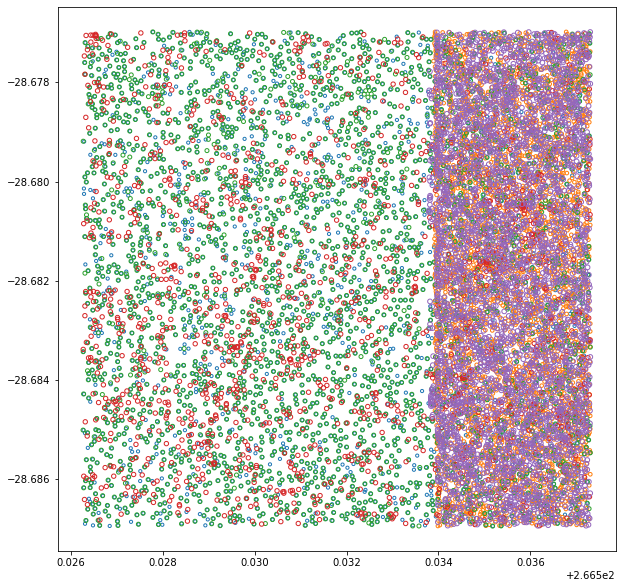

In [19]:
pl.figure(figsize=(10,10))
ax = pl.gca()
for ii, (ww, tbl) in enumerate(zip(wcses, tbls)):
    crds = tbl['skycoords']
    crds = crds[reg.contains(crds, ww)]
    markers = ax.scatter(crds.ra, crds.dec, s=10+3*ii)
    markers.set_edgecolors(markers.get_facecolors())
    markers.set_facecolors('none')
ax.axis()

In [20]:
tbls[0].meta['filter'], len(tbls[0])

('f410m', 73738)

In [21]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    basetable = tbls[0].copy()
    basecrds = basetable['skycoords']
    for colname in basetable.colnames:
        basetable.rename_column(colname, colname+"_"+basetable.meta['filter'])
    #basetable = basetable[[cn for cn in basetable.colnames if not any(x in cn for x in ignored_columns)]]

    for tbl in tbls[1:]:
        wl = tbl.meta['filter']
        print(wl)
        #tbl = tbl[[cn for cn in tbl.colnames if not any(x in cn for x in ignored_columns)]]
        crds = tbl['skycoords']
        matches, sep, _ = basecrds.match_to_catalog_sky(crds, nthneighbor=1)
        basetable.add_column(name=f"sep_{wl}", col=sep)
        basetable.add_column(name=f"id_{wl}", col=matches)
        matchtb = tbl[matches]
        for cn in matchtb.colnames:
            #matchtb[cn][sep > 0.1*u.arcsec].mask = True
            matchtb.rename_column(cn, f"{cn}_{wl}")
        basetable = table.hstack([basetable, matchtb], join_type='exact')
        basetable.meta[f'{wl}_pixelscale'] = tbl.meta['pixelscale']
        #if 'sky_centroid_f444w' in basetable.colnames:
        #    basetable.rename_column('sky_centroid_f444w', 'sky_centroid')
        #basetable = table.join(basetable, tbl,
        #                      table_names=['', wl],
        #                      join_type='outer',
        #                      join_funcs={'sky_centroid': table.join_skycoord(0.1*u.arcsec)})
        #if 'sky_centroid_' in basetable.colnames:
        #    basetable.rename_column('sky_centroid_', 'sky_centroid_f444w')
        basetable.write(f"{basepath}/catalogs/crowdsource_nrcb_photometry_tables_merged.ecsv", overwrite=True)
        basetable.write(f"{basepath}/catalogs/crowdsource_nrcb_photometry_tables_merged.fits", overwrite=True)

f466n
f405n
f187n
f182m


In [45]:
# Line-subtract the F410 continuum band
basetable.add_column(basetable['flux_jy_f410m'] - basetable['flux_jy_f405n'] * 0.16, name='flux_jy_410m405')
basetable.add_column(basetable['flux_jy_410m405'].to(u.ABmag), name='mag_ab_410m405')
# Then subtract that remainder back from the F405 band to get the continuum-subtracted F405
basetable.add_column(basetable['flux_jy_f405n'] - basetable['flux_jy_410m405'], name='flux_jy_405m410')
basetable.add_column(basetable['flux_jy_405m410'].to(u.ABmag), name='mag_ab_405m410')

ValueError: Cannot replace column 'flux_jy_410m405'.  Use Table.replace_column() instead.

0arcsec [0arcsec 0arcsec 0arcsec ... 0arcsec 0arcsec 0arcsec]
0arcsec
0.924798arcsec [0.199166arcsec 0.201497arcsec 0.24584arcsec ... -0.030335arcsec
 -0.119782arcsec -0.218284arcsec]
0.189249arcsec
-0.0198634arcsec [-0.0841834arcsec -0.0355568arcsec -0.0987422arcsec ... -0.0290011arcsec
 -0.0117303arcsec 0.148253arcsec]
0.00717573arcsec
0.00627274arcsec [0.14306arcsec -0.073777arcsec -0.073157arcsec ... -0.242511arcsec
 0.231172arcsec 0.0318942arcsec]
0.00479863arcsec
1.45171arcsec [0.167631arcsec 0.227513arcsec 0.0984243arcsec ... 0.103565arcsec
 -0.0485685arcsec -0.190143arcsec]
0.449026arcsec


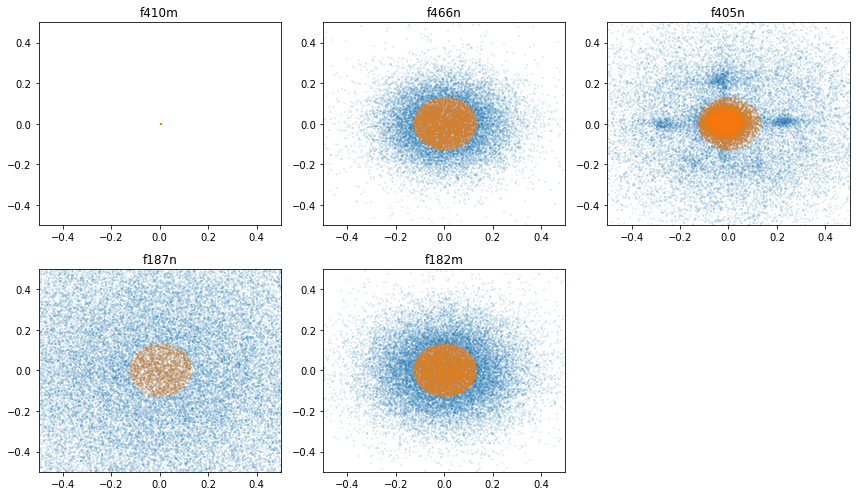

In [23]:
pl.figure(figsize=(12,7))
basecrds = basetable['skycoords_f410m']
ii = 1
for tbl in tbls:
    ax = pl.subplot(2,3,ii)
    filtername = tbl.meta['filter']
    #print(ii, filtername)
    crds = basetable[f'skycoords_{filtername}']
    radiff = (crds.ra-basecrds.ra).to(u.arcsec)
    decdiff = (crds.dec-basecrds.dec).to(u.arcsec)
    print(np.median(radiff), radiff[np.abs(radiff) < 0.25*u.arcsec])
    print(np.median(decdiff))
    ok = (radiff**2 + decdiff**2) < (0.13*u.arcsec)**2
    ax.scatter(radiff, decdiff, marker=',', s=1, alpha=0.1)
    ax.scatter(radiff[ok], decdiff[ok], marker=',', s=1, alpha=0.1)
    ax.axis([-0.5, 0.5, -0.5, 0.5])
    ax.set_title(filtername)
    ii += 1
pl.tight_layout()

In [24]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    
    basetable = Table.read(f"{basepath}/catalogs/crowdsource_nrcb_photometry_tables_merged.ecsv")
    
    basecrds = basetable['skycoords_f410m']
    for tbl in tbls[1:]:
        wl = tbl.meta['filter']
        crds = basetable[f'skycoords_{wl}']
        radiff = (crds.ra-basecrds.ra).to(u.arcsec)
        decdiff = (crds.dec-basecrds.dec).to(u.arcsec)
        oksep = basetable[f'sep_{wl}'] < 0.25*u.arcsec
        medsep_ra, medsep_dec = np.median(radiff[oksep]), np.median(decdiff[oksep])
        print(wl, medsep_ra, medsep_dec)
        newcrds = SkyCoord(crds.ra - medsep_ra, crds.dec - medsep_dec, frame=crds.frame)
        basetable[f'skycoords_{wl}'] = newcrds
        matches, sep, _ = basecrds.match_to_catalog_sky(newcrds, nthneighbor=1)
        basetable[f"sep_{wl}"] = sep
        basetable[f"id_{wl}"] = matches
        basetable.write(f"{basepath}/catalogs/crowdsource_nrcb_photometry_tables_merged_offsetcorrected.ecsv", overwrite=True)
        basetable.write(f"{basepath}/catalogs/crowdsource_nrcb_photometry_tables_merged_offsetcorrected.fits", overwrite=True)

f466n -0.00256402arcsec -0.00231515arcsec
f405n -0.0199911arcsec 0.00721598arcsec
f187n 0.00118682arcsec -0.000670395arcsec
f182m 0.000758808arcsec -0.00141675arcsec


In [45]:
# Line-subtract the F410 continuum band
basetable.add_column(basetable['flux_jy_f410m'] - basetable['flux_jy_f405n'] * 0.16, name='flux_jy_410m405')
basetable.add_column(basetable['flux_jy_410m405'].to(u.ABmag), name='mag_ab_410m405')
# Then subtract that remainder back from the F405 band to get the continuum-subtracted F405
basetable.add_column(basetable['flux_jy_f405n'] - basetable['flux_jy_410m405'], name='flux_jy_405m410')
basetable.add_column(basetable['flux_jy_405m410'].to(u.ABmag), name='mag_ab_405m410')

ValueError: Cannot replace column 'flux_jy_410m405'.  Use Table.replace_column() instead.

f466n 22.618908865039735 arcsec 0.08753887075273867 arcsec
f405n 0.01998345355197719 arcsec 0.012892769421870847 arcsec
f187n 0.6145116831071271 arcsec 0.09135171493306471 arcsec
f182m 20.57509434676423 arcsec 0.08681978188078789 arcsec


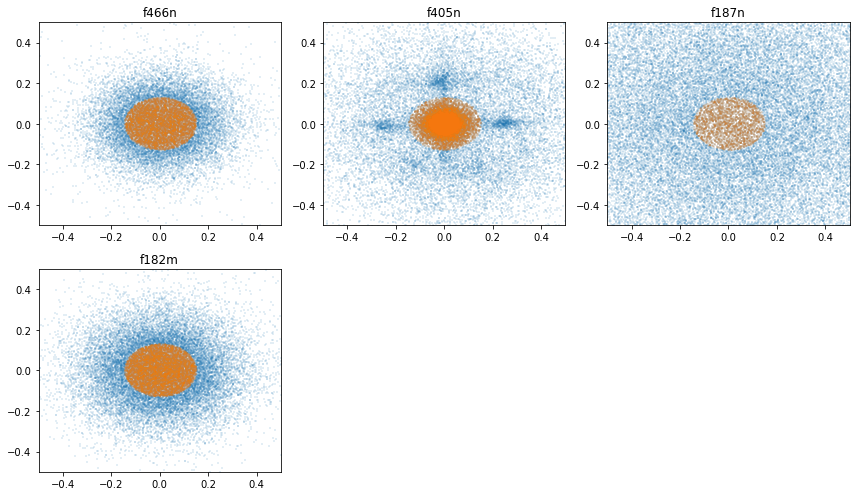

In [25]:
pl.figure(figsize=(12,7))
basecrds = basetable['skycoords_f410m']
ii = 1
for tbl in tbls[1:]:
    ax = pl.subplot(2,3,ii)
    filtername = tbl.meta['filter']
    #print(ii, filtername)
    crds = basetable[f'skycoords_{filtername}']
    radiff = (crds.ra-basecrds.ra).to(u.arcsec)
    decdiff = (crds.dec-basecrds.dec).to(u.arcsec)
    #print(np.median(radiff), radiff[np.abs(radiff) < 0.25*u.arcsec])
    #print(np.median(decdiff))
    sep = basetable[f'sep_{filtername}']
    print(filtername, np.median(sep.to(u.arcsec)), np.median(sep[sep<0.13*u.arcsec].to(u.arcsec)))
    ok = sep < (0.13*u.arcsec)
    ax.scatter(radiff, decdiff, marker=',', s=1, alpha=0.1)
    ax.scatter(radiff[ok], decdiff[ok], marker=',', s=1, alpha=0.1)
    ax.axis([-0.5, 0.5, -0.5, 0.5])
    ax.set_title(filtername)
    ii += 1
pl.tight_layout()

In [26]:
len(basetable)

73738

In [27]:
basetable[reg.contains(basetable['skycoords_f405n'],ww)][:5]

<Table length=5>
     x_f410m            y_f410m      flux_f410m passno_f410m   dx_f410m    dy_f410m  dflux_f410m  qf_f410m rchi2_f410m fracflux_f410m ... spread_model_f182m dspread_model_f182m fluxiso_f182m      xiso_f182m          yiso_f182m     sky_f182m            skycoords_f182m             flux_jy_f182m  mag_ab_f182m
                                                                                                                                      ...                                                                                                                       deg,deg                       Jy         mag(AB)   
     float64            float64       float32     float64      float32     float32     float32    float32    float32      float32     ...      float32             float32          float32          float64             float64        float32                 SkyCoord                   float32       float32   
------------------ ----------------- ---------- ------------ ----------- ----------- ----------- --------- ----------- -------------- ... ------------------ ------------------- ------------- ------------------- ------------------- --------- -------------------------------------- -------------- ------------
1544.8462179124251 688.1997705567804  44.778423          0.0 0.018757038 0.016982058  0.46776444 0.9999999    64.76323      0.7793824 ...         0.07530731        0.0059205354    -17.946672 -3.9370298829074657 -0.9492217478060095  5.863143 266.53397697847174,-28.686958867996562 -3.4338111e-06          nan
1586.4876879354765  687.655511004026   70.60596          0.0 0.011213218 0.011480445  0.45896053 0.9999999   104.82131      0.8842218 ...         0.13911968         0.039626494     -6.532884 -0.6831286794865367  3.0844207975343294 5.6269684   266.53397918264204,-28.6860142270572  -9.781544e-07          nan
  1649.29636296098 689.7005288501298   -15.1455          0.0 0.050849635 0.044775546   0.3693734       1.0   95.667534     -0.5566365 ...        0.042811394       0.00016203153    -308113.28  0.3684974580676243 0.25131899032671123 6.3984184   266.5338358395036,-28.68452313379621    0.041587554   12.3525915
  1652.77008422778 688.2392337551469 12.1003685          0.0 0.058886696 0.059117213  0.39622328 0.9999999  127.606834      0.7379737 ...        0.042811394       0.00016203153    -308113.28  0.3684974580676243 0.25131899032671123 6.3984184   266.5338358395036,-28.68452313379621    0.041587554   12.3525915
1548.7042611539298 689.5614875805139  102.96115          0.0 0.007916699 0.008092537  0.49970046 1.0000001   111.94475     0.94916767 ...         0.07530731        0.0059205354    -17.946672 -3.9370298829074657 -0.9492217478060095  5.863143 266.53397697847174,-28.686958867996562 -3.4338111e-06          nan

In [28]:
basetable[reg.contains(basetable['skycoords_f410m'],ww)][:5]['flux_f410m', 'skycoords_f410m', 'x_f410m', 'y_f410m']

<Table length=5>
flux_f410m            skycoords_f410m                  x_f410m            y_f410m     
                          deg,deg                                                     
 float32                  SkyCoord                     float64            float64     
---------- -------------------------------------- ------------------ -----------------
 44.778423   266.526310311114,-28.686897022734524 1544.8462179124251 688.1997705567804
  70.60596 266.52628683307574,-28.686168526202284 1586.4876879354765  687.655511004026
  -15.1455 266.52630858497685,-28.685068958006593   1649.29636296098 689.7005288501298
12.1003685 266.52627838521164,-28.685008563503033   1652.77008422778 688.2392337551469
 102.96115  266.5263363028117,-28.686829152704757 1548.7042611539298 689.5614875805139

In [29]:
#(500*u.Jy).to(u.ABmag)
(basetable[reg.contains(basetable['skycoords_f410m'],ww)][:5]['flux_f410m'] * u.Jy).to(u.ABmag)

/orange/adamginsburg/miniconda3/envs/python39/lib/python3.9/site-packages/astropy/units/function/logarithmic.py:47: RuntimeWarning: invalid value encountered in log10
  return dex.to(self._function_unit, np.log10(x))


<Magnitude [4.7723284, 4.2778964,       nan, 6.1930037, 3.8683164] mag(AB)>

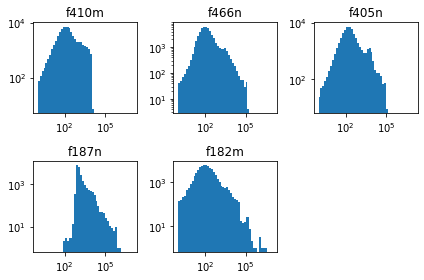

In [32]:
for ii, tbl in enumerate(tbls):
    ax = pl.subplot(2,3,ii+1)
    ax.hist(tbl['flux'], bins=np.logspace(0,7), log=True)
    ax.set_title(tbl.meta['filter'])
    ax.loglog()
pl.tight_layout()

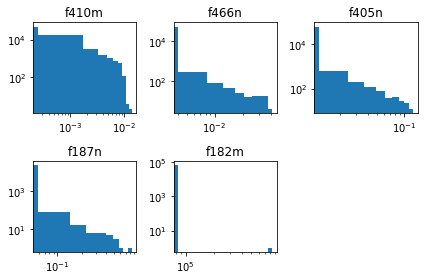

In [33]:
for ii, tbl in enumerate(tbls):
    ax = pl.subplot(2,3,ii+1)
    ax.hist(tbl['flux_jy'], log=True)
    ax.set_title(tbl.meta['filter'])
    ax.loglog()
pl.tight_layout()

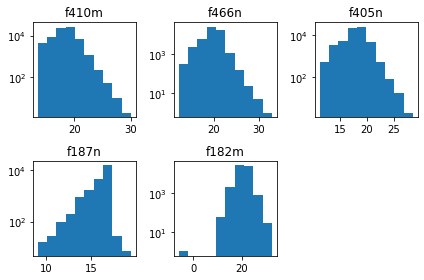

In [34]:
for ii, tbl in enumerate(tbls):
    ax = pl.subplot(2,3,ii+1)
    ax.hist(tbl['mag_ab'], log=True)
    ax.set_title(tbl.meta['filter'])
    #ax.loglog()
pl.tight_layout()

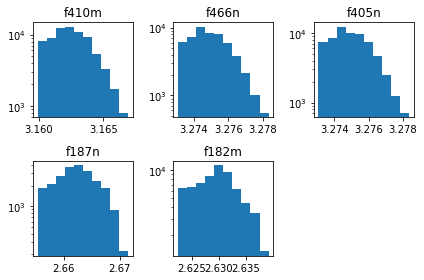

In [35]:
for ii, tbl in enumerate(tbls):
    ax = pl.subplot(2,3,ii+1)
    ax.hist(tbl['fwhm'], log=True)
    ax.set_title(tbl.meta['filter'])
pl.tight_layout()

# XMatch Check

In [36]:
len(tbls[0]), tbls[0].meta['filter']

(73738, 'f410m')

In [37]:
fh = fits.open(f'{basepath}/F410M/pipeline/jw02221-o001_t001_nircam_clear-f410m-nrcb_i2d.fits')
ww410 = wcs.WCS(fh[1].header)

Set DATE-AVG to '2022-08-28T03:05:33.037' from MJD-AVG.
Set DATE-END to '2022-08-28T03:34:03.365' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -20.644641 from OBSGEO-[XYZ].
Set OBSGEO-H to 1526209006.388 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


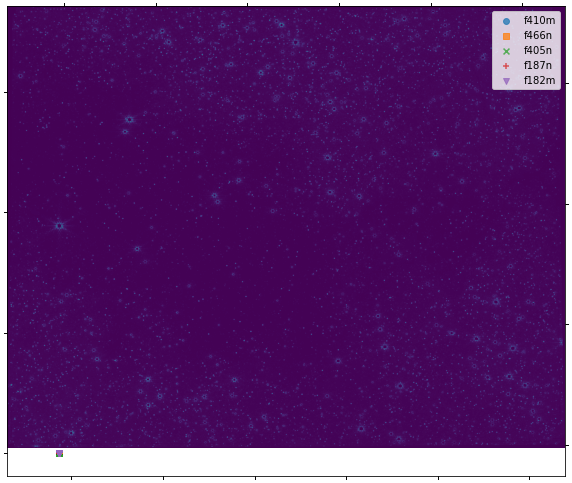

In [39]:
pl.figure(figsize=(10,10))
ax = pl.subplot(projection=ww410)
data410 = imgs[0]
ax.imshow(data410)
for tbl,marker in zip(tbls, 'osx+v*'):
    crds = tbl['skycoords']
    pl.scatter(crds.ra, crds.dec, alpha=0.75, s=35,
               marker=marker, label=tbl.meta['filter'])
#pl.axis((266.5385, 266.54, -28.740, -28.7385))
pl.legend(loc='best')

# Color-magnitude and color-color diagrams

(25.0, 13.0)

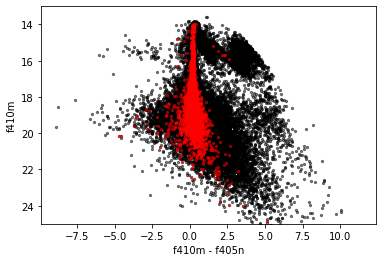

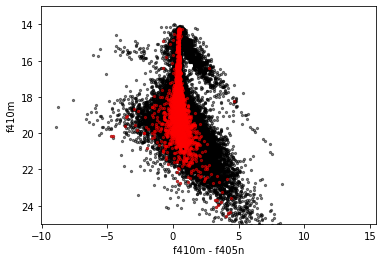

In [46]:
sel = reg.contains(basetable['skycoords_f410m'], ww)
sel &= basetable['sep_f405n'].quantity < 0.1*u.arcsec
pl.scatter(basetable['mag_ab_f410m'] - basetable['mag_ab_f405n'], basetable['mag_ab_f410m'], s=5, alpha=0.5, c='k')
pl.scatter((basetable['mag_ab_f410m'] - basetable['mag_ab_f405n'])[sel], basetable['mag_ab_f410m'][sel], s=5, alpha=0.5, c='r')
pl.ylim(pl.ylim()[::-1])
pl.xlabel("f410m - f405n")
pl.ylabel("f410m")
pl.ylim(25,13)

pl.figure()
pl.scatter(basetable['mag_ab_410m405'] - basetable['mag_ab_f405n'], basetable['mag_ab_410m405'], s=5, alpha=0.5, c='k')
pl.scatter((basetable['mag_ab_410m405'] - basetable['mag_ab_f405n'])[sel], basetable['mag_ab_410m405'][sel], s=5, alpha=0.5, c='r')
pl.ylim(pl.ylim()[::-1])
pl.xlabel("f410m - f405n")
pl.ylabel("f410m")
pl.ylim(25,13)

(25.0, 14.0)

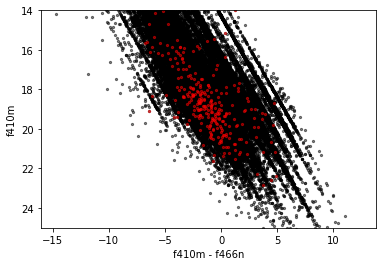

In [47]:
sel = reg.contains(basetable['skycoords_f410m'], ww)
sel &= basetable['sep_f466n'].quantity < 0.1*u.arcsec
pl.scatter(basetable['mag_ab_f410m'] - basetable['mag_ab_f466n'], basetable['mag_ab_f410m'], s=5, alpha=0.5, c='k')
pl.scatter((basetable['mag_ab_f410m'] - basetable['mag_ab_f466n'])[sel], basetable['mag_ab_f410m'][sel], s=5, alpha=0.5, c='r')
pl.ylim(pl.ylim()[::-1])
pl.xlabel("f410m - f466n")
pl.ylabel("f410m")
pl.ylim(25,14)

(-5.0, 10.0, -5.0, 10.0)

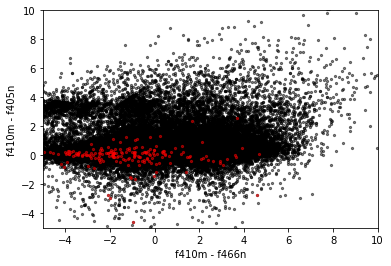

In [75]:
sel = reg.contains(basetable['skycoords_f410m'], ww)
sel &= basetable['sep_f466n'].quantity < 0.1*u.arcsec
sel &= basetable['sep_f405n'].quantity < 0.1*u.arcsec
sel2 = regzoom.contains(basetable['skycoords_f410m'], ww)
sel2 &= basetable['sep_f466n'].quantity < 0.1*u.arcsec
sel2 &= basetable['sep_f405n'].quantity < 0.1*u.arcsec
pl.scatter(basetable['mag_ab_f410m'] - basetable['mag_ab_f466n'], basetable['mag_ab_f410m']-basetable['mag_ab_f405n'], s=5, alpha=0.5, c='k')
pl.scatter((basetable['mag_ab_f410m'] - basetable['mag_ab_f466n'])[sel], (basetable['mag_ab_f410m']-basetable['mag_ab_f405n'])[sel], s=5, alpha=0.5, c='r')
pl.scatter((basetable['mag_ab_f410m'] - basetable['mag_ab_f466n'])[sel2], (basetable['mag_ab_f410m']-basetable['mag_ab_f405n'])[sel2], s=5, alpha=0.5, c='g')
pl.ylim(pl.ylim()[::-1])
pl.xlabel("f410m - f466n")
pl.ylabel("f410m - f405n")
pl.axis((-5,10,-5,10))

(-5.0, 10.0, -5.0, 10.0)

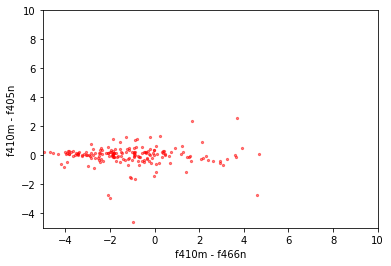

In [76]:
sel = reg.contains(basetable['skycoords_f410m'], ww)
sel &= basetable['sep_f466n'].quantity < 0.1*u.arcsec
sel &= basetable['sep_f405n'].quantity < 0.1*u.arcsec
sel2 = regzoom.contains(basetable['skycoords_f410m'], ww)
sel2 &= basetable['sep_f466n'].quantity < 0.1*u.arcsec
sel2 &= basetable['sep_f405n'].quantity < 0.1*u.arcsec
#pl.scatter(basetable['mag_ab_f410m'] - basetable['mag_ab_f466n'], basetable['mag_ab_f410m']-basetable['mag_ab_f405n'], s=5, alpha=0.5, c='k')
pl.scatter((basetable['mag_ab_f410m'] - basetable['mag_ab_f466n'])[sel], (basetable['mag_ab_f410m']-basetable['mag_ab_f405n'])[sel], s=5, alpha=0.5, c='r')
pl.scatter((basetable['mag_ab_f410m'] - basetable['mag_ab_f466n'])[sel2], (basetable['mag_ab_f410m']-basetable['mag_ab_f405n'])[sel2], s=5, alpha=0.5, c='g')
pl.ylim(pl.ylim()[::-1])
pl.xlabel("f410m - f466n")
pl.ylabel("f410m - f405n")
pl.axis((-5,10,-5,10))

(-5.0, 10.0, -5.0, 10.0)

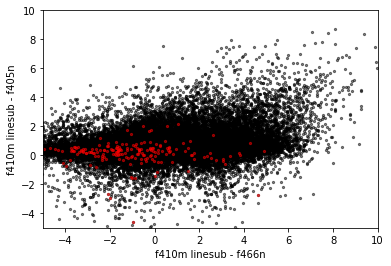

In [77]:
sel = reg.contains(basetable['skycoords_f410m'], ww)
sel &= basetable['sep_f466n'].quantity < 0.1*u.arcsec
sel &= basetable['sep_f405n'].quantity < 0.1*u.arcsec
sel2 = regzoom.contains(basetable['skycoords_f410m'], ww)
sel2 &= basetable['sep_f466n'].quantity < 0.1*u.arcsec
sel2 &= basetable['sep_f405n'].quantity < 0.1*u.arcsec
pl.scatter(basetable['mag_ab_410m405'] - basetable['mag_ab_f466n'], basetable['mag_ab_410m405']-basetable['mag_ab_f405n'], s=5, alpha=0.5, c='k')
pl.scatter((basetable['mag_ab_410m405'] - basetable['mag_ab_f466n'])[sel], (basetable['mag_ab_410m405']-basetable['mag_ab_f405n'])[sel], s=5, alpha=0.5, c='r')
pl.scatter((basetable['mag_ab_410m405'] - basetable['mag_ab_f466n'])[sel2], (basetable['mag_ab_410m405']-basetable['mag_ab_f405n'])[sel2], s=5, alpha=0.5, c='g')
pl.ylim(pl.ylim()[::-1])
pl.xlabel("f410m linesub - f466n")
pl.ylabel("f410m linesub - f405n")
pl.axis((-5,10,-5,10))

(25.0, 14.0)

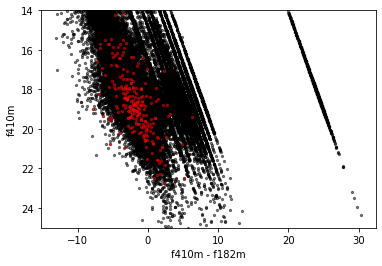

In [78]:
sel = reg.contains(basetable['skycoords_f410m'], ww)
sel &= basetable['sep_f182m'].quantity < 0.1*u.arcsec
pl.scatter(basetable['mag_ab_f410m'] - basetable['mag_ab_f182m'], basetable['mag_ab_f410m'], s=5, alpha=0.5, c='k')
pl.scatter((basetable['mag_ab_f410m'] - basetable['mag_ab_f182m'])[sel], basetable['mag_ab_f410m'][sel], s=5, alpha=0.5, c='r')
pl.xlabel("f410m - f182m")
pl.ylabel("f410m")
pl.ylim(25,14)

In [79]:
sel = reg.contains(basetable['skycoords_f212n'], ww)
pl.scatter(basetable['mag_ab_f212n'] - basetable['mag_ab_f182m'], basetable['mag_ab_f212n'], s=5, alpha=0.5, c='k')
pl.scatter((basetable['mag_ab_f212n'] - basetable['mag_ab_f182m'])[sel], basetable['mag_ab_f212n'][sel], s=5, alpha=0.5, c='r')
pl.ylim(pl.ylim()[::-1])
pl.xlabel("f212n - f182m")
pl.ylabel("f212n")
pl.ylim(25,14)

KeyError: 'skycoords_f212n'

0arcsec [0arcsec 0arcsec 0arcsec ... 0arcsec 0arcsec 0arcsec]
0arcsec
0.927362arcsec [0.20173arcsec 0.204061arcsec 0.248404arcsec ... -0.027771arcsec
 -0.117218arcsec -0.21572arcsec]
0.191564arcsec
0.000127646arcsec [-0.0641924arcsec -0.0155658arcsec -0.0787512arcsec ... -0.00901arcsec
 0.00826075arcsec 0.168244arcsec]
-4.02451e-05arcsec
0.00508592arcsec [0.141873arcsec -0.0749638arcsec -0.0743438arcsec ... -0.243698arcsec
 0.229985arcsec 0.0307074arcsec]
0.00546903arcsec
1.45095arcsec [0.166872arcsec 0.226754arcsec 0.0976655arcsec ... 0.102806arcsec
 -0.0493273arcsec -0.190902arcsec]
0.450443arcsec


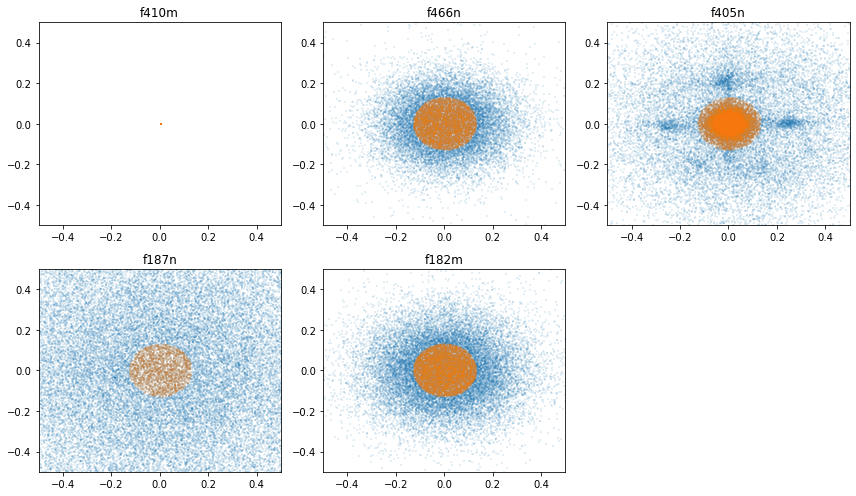

In [80]:
pl.figure(figsize=(12,7))
basecrds = basetable['skycoords_f410m']
ii = 1
for tbl in tbls:
    ax = pl.subplot(2,3,ii)
    filtername = tbl.meta['filter']
    #print(ii, filtername)
    crds = basetable[f'skycoords_{filtername}']
    radiff = (crds.ra-basecrds.ra).to(u.arcsec)
    decdiff = (crds.dec-basecrds.dec).to(u.arcsec)
    print(np.median(radiff), radiff[np.abs(radiff) < 0.25*u.arcsec])
    print(np.median(decdiff))
    ok = (radiff**2 + decdiff**2) < (0.13*u.arcsec)**2
    ax.scatter(radiff, decdiff, marker=',', s=1, alpha=0.1)
    ax.scatter(radiff[ok], decdiff[ok], marker=',', s=1, alpha=0.1)
    ax.axis([-0.5, 0.5, -0.5, 0.5])
    ax.set_title(filtername)
    ii += 1
pl.tight_layout()

In [81]:
import PIL
import pyavm

In [82]:
avm = pyavm.AVM.from_image(f'{basepath}/images/BrickJWST_longwave_RGB_unrotated.png')
img = np.array(PIL.Image.open(f'{basepath}/images/BrickJWST_longwave_RGB_unrotated.png'))[::-1,:,:]
#wwi = avm.to_wcs(use_full_header=True)
wwi = wcs.WCS(fits.Header.fromstring(avm.Spatial.FITSheader))

Set DATE-AVG to '2022-08-28T03:05:32.473' from MJD-AVG.
Set DATE-END to '2022-08-28T03:34:03.557' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -20.651775 from OBSGEO-[XYZ].
Set OBSGEO-H to 1526292809.682 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


In [83]:
# This image shows "CO-absorbed" stars as purple
avm = pyavm.AVM.from_image(f'{basepath}/images/BrickJWST_nrcb_longwave_stars_rotated.png')
img = np.array(PIL.Image.open(f'{basepath}/images/BrickJWST_nrcb_longwave_stars_rotated.png'))[::-1,:,:]
#wwi = avm.to_wcs(use_full_header=True)
wwi = wcs.WCS(fits.Header.fromstring(avm.Spatial.FITSheader))

Set DATE-AVG to '2022-08-28T03:05:33.037' from MJD-AVG.
Set DATE-END to '2022-08-28T03:34:03.365' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -20.644641 from OBSGEO-[XYZ].
Set OBSGEO-H to 1526209006.388 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


In [84]:
wwi

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 266.5356077805302  -28.68865888908035  
CRPIX : 1437.960448907717  1153.599462872148  
PC1_1 PC1_2  : -0.01527282179577138  0.9998833636551788  
PC2_1 PC2_2  : 0.9998833636551788  0.01527282179577138  
CDELT : 1.74999920687403e-05  1.74999920687403e-05  
NAXIS : 2900  2296

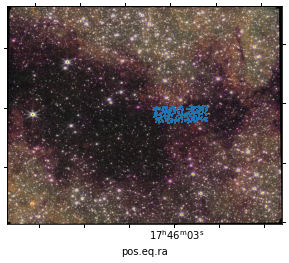

In [85]:
ax = pl.subplot(projection=wwi)
ax.imshow(img)
crds = basetable['skycoords_f410m']
ax.scatter(crds.ra[sel], crds.dec[sel], transform=ax.get_transform('fk5'), marker=',', s=1)

In [86]:
reg.center.to_string('hmsdms')
reg.to_pixel(wwi),img.shape
reg.to_pixel(wwi).to_mask().get_overlap_slices([2296,2900])
mask = reg.to_pixel(wwi).to_mask()
slcs,_ = mask.get_overlap_slices(img.shape[:2])
slcs

(slice(686, 1249, None), slice(1534, 2112, None))

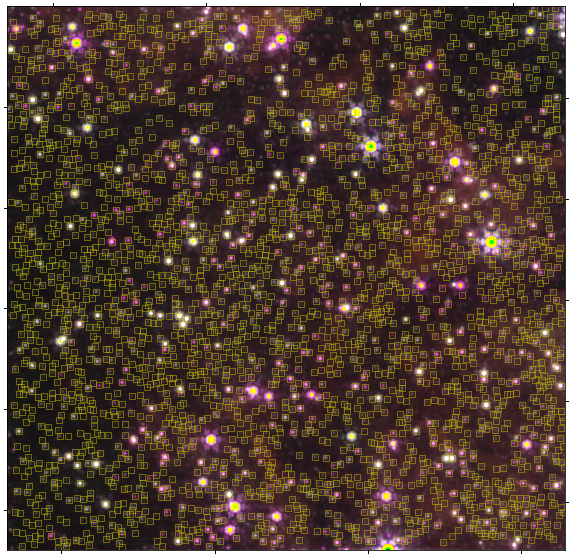

In [87]:
mask = reg.to_pixel(wwi).to_mask()
slcs,_ = mask.get_overlap_slices(img.shape[:2])
#co = np.array([mask.cutout(img[:,:,ii]) for ii in range(img.shape[2])])
co = img[slcs[0], slcs[1], :]

pl.figure(figsize=(10,10))
ax = pl.subplot(projection=wwi[slcs])
pl.imshow(co)

crds = basetable['skycoords_f410m']
sel = reg.contains(crds, ww410)
xx,yy = ww410[slcs].world_to_pixel(crds[sel])

colorby = basetable['flux_f410m']
colorby = basetable['mag_ab_f410m'] - basetable['mag_ab_f405n']
#sel = sel & (colorby > 2)
sel &= basetable['sep_f405n'].quantity < 0.1*u.arcsec

scat = ax.scatter(crds.ra[sel], crds.dec[sel], transform=ax.get_transform('world'),
                  edgecolor='y', facecolor='none', marker='s',
                  alpha=0.5)#r'$\rightarrow$')
                  #c=colorby[sel],
                  #norm=simple_norm(colorby[sel], stretch='linear',), cmap='jet')
#pl.draw()
#colors = scat.get_facecolors()
#scat.set_edgecolors(colors)
#scat.set_facecolors('none')

In [88]:

mask = regzoom.to_pixel(wwi).to_mask()
slcs,_ = mask.get_overlap_slices(img.shape[:2])
regzoom

<RectangleSkyRegion(center=<SkyCoord (ICRS): (ra, dec) in deg
    (266.53097552, -28.681656)>, width=13.1392 arcsec, height=12.4669 arcsec, angle=0.0 deg)>

In [89]:
regzoom.center.to_string('hmsdms'), reg.center.to_string('hmsdms')


('17h46m07.43412528s -28d40m53.9616108s',
 '17h46m07.62833016s -28d40m55.0634448s')

(25.0, 14.0)

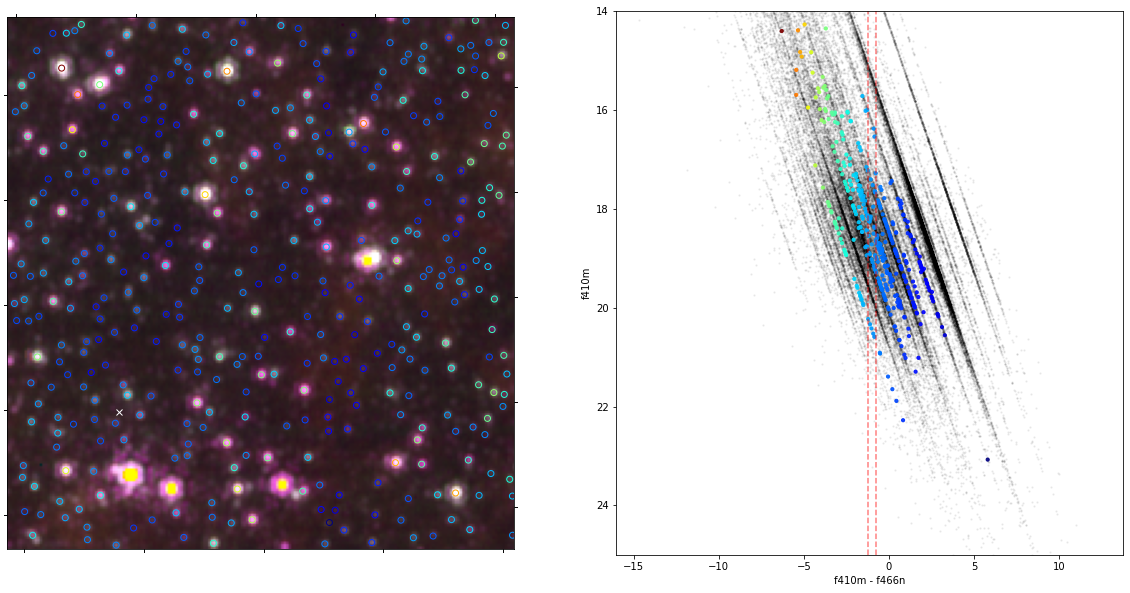

In [90]:
mask = regzoom.to_pixel(wwi).to_mask()
slcs,_ = mask.get_overlap_slices(img.shape[:2])
#co = np.array([mask.cutout(img[:,:,ii]) for ii in range(img.shape[2])])
co = img[slcs[0], slcs[1], :]

pl.figure(figsize=(20,10))
ax = pl.subplot(1,2,1, projection=wwi[slcs])
pl.imshow(co)

crds = basetable['skycoords_f410m']
sel = regzoom.contains(crds, ww410)
sel &= basetable['sep_f405n'].quantity < 0.1*u.arcsec
xx,yy = ww410[slcs].world_to_pixel(crds[sel])

colorby = basetable['flux_f410m']
colorby = basetable['mag_ab_f410m'] - basetable['mag_ab_f405n']
colorby = basetable['mag_ab_f410m'] - basetable['mag_ab_f466n']
#sel = sel & (colorby < -2)

scat = ax.scatter(crds.ra[sel], crds.dec[sel], transform=ax.get_transform('world'),
                  #edgecolor='r', facecolor='none', marker='s')#r'$\rightarrow$')
                  c=colorby[sel],
                  norm=simple_norm(colorby[sel], stretch='asinh',), cmap='jet_r')
pl.draw()
colors = scat.get_facecolors()
scat.set_edgecolors(colors)
scat.set_facecolors('none')
#pl.colorbar(mappable=scat)
ax.axis()
pl.plot(44,54, 'wx')
wwi[slcs].pixel_to_world(45,55)

ax2 = pl.subplot(1,2,2)
ax2.scatter(basetable['mag_ab_f410m'] - basetable['mag_ab_f466n'], basetable['mag_ab_f410m'], s=2, alpha=0.05, c='k')
ax2.scatter((basetable['mag_ab_f410m'] - basetable['mag_ab_f466n'])[sel], basetable['mag_ab_f410m'][sel], s=10, alpha=0.9,
            c=colorby[sel],
            norm=simple_norm(colorby[sel], stretch='asinh',), cmap='jet_r'
           )
ax2.axvline(-0.75, linestyle='--', color='r', alpha=0.5)
ax2.axvline(-1.25, linestyle='--', color='r', alpha=0.5)
ax2.set_ylim(pl.ylim()[::-1])
ax2.set_xlabel("f410m - f466n")
ax2.set_ylabel("f410m")
ax2.set_ylim(25,14)

Set DATE-AVG to '2022-08-28T03:05:33.037' from MJD-AVG.
Set DATE-END to '2022-08-28T03:34:03.365' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -20.644641 from OBSGEO-[XYZ].
Set OBSGEO-H to 1526209006.388 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


(25.0, 14.0)

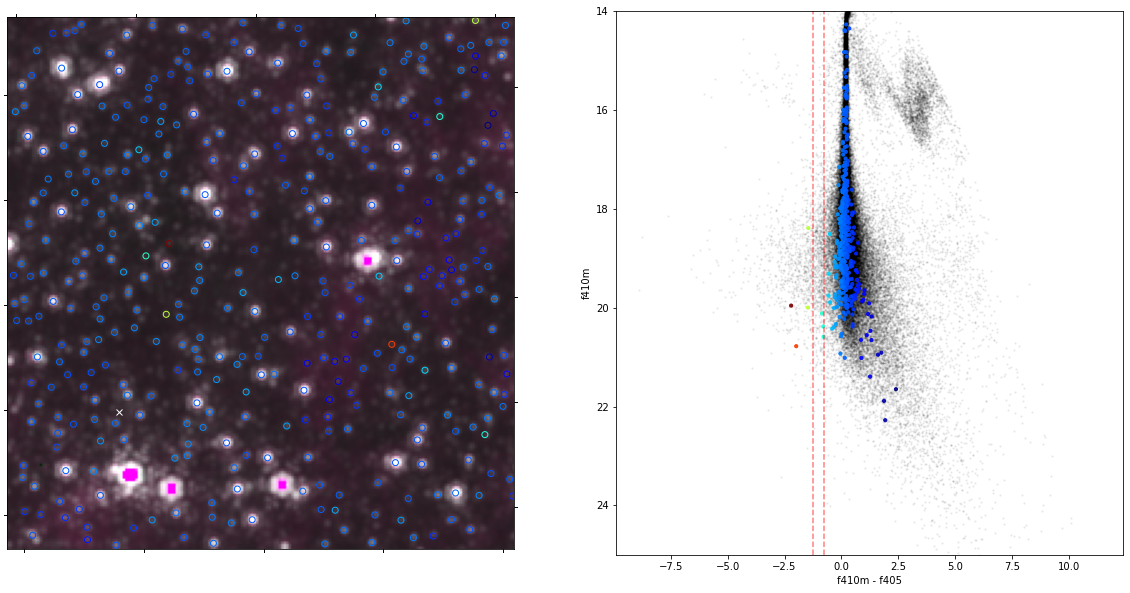

In [91]:
# This image shows only H-alpha stars
avm = pyavm.AVM.from_image(f'{basepath}/images/BrickJWST_nrcb_longwave_stars_bra_410.png')
img_bra_410 = np.array(PIL.Image.open(f'{basepath}/images/BrickJWST_nrcb_longwave_stars_bra_410.png'))[::-1,:,:]
#wwi_bra_410 = avm.to_wcs(use_full_header=True)
wwi_bra_410 = wcs.WCS(fits.Header.fromstring(avm.Spatial.FITSheader))

mask = regzoom.to_pixel(wwi_bra_410).to_mask()
slcs,_ = mask.get_overlap_slices(img_bra_410.shape[:2])
#co = np.array([mask.cutout(img_bra_410[:,:,ii]) for ii in range(img_bra_410.shape[2])])
co = img_bra_410[slcs[0], slcs[1], :]

pl.figure(figsize=(20,10))
ax = pl.subplot(1,2,1, projection=wwi_bra_410[slcs])
pl.imshow(co)

crds = basetable['skycoords_f410m']
sel = regzoom.contains(crds, ww410)
sel &= basetable['sep_f405n'].quantity < 0.1*u.arcsec
xx,yy = ww410[slcs].world_to_pixel(crds[sel])

colorby = basetable['flux_f410m']
colorby = basetable['mag_ab_f410m'] - basetable['mag_ab_f405n']
#sel = sel & (colorby < -2)

scat = ax.scatter(crds.ra[sel], crds.dec[sel], transform=ax.get_transform('world'),
                  #edgecolor='r', facecolor='none', marker='s')#r'$\rightarrow$')
                  c=colorby[sel],
                  norm=simple_norm(colorby[sel], stretch='asinh',), cmap='jet_r')
pl.draw()
colors = scat.get_facecolors()
scat.set_edgecolors(colors)
scat.set_facecolors('none')
#pl.colorbar(mappable=scat)
ax.axis()
pl.plot(44,54, 'wx')
wwi_bra_410[slcs].pixel_to_world(45,55)

ax2 = pl.subplot(1,2,2)
ax2.scatter(basetable['mag_ab_f410m'] - basetable['mag_ab_f405n'], basetable['mag_ab_f410m'], s=2, alpha=0.05, c='k')
ax2.scatter((basetable['mag_ab_f410m'] - basetable['mag_ab_f405n'])[sel], basetable['mag_ab_f410m'][sel], s=10, alpha=0.9,
            c=colorby[sel],
            norm=simple_norm(colorby[sel], stretch='asinh',), cmap='jet_r'
           )
ax2.axvline(-0.75, linestyle='--', color='r', alpha=0.5)
ax2.axvline(-1.25, linestyle='--', color='r', alpha=0.5)
ax2.set_ylim(pl.ylim()[::-1])
ax2.set_xlabel("f410m - f405")
ax2.set_ylabel("f410m")
ax2.set_ylim(25,14)

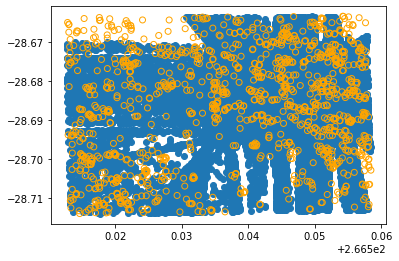

In [92]:
blue_410_466 = (basetable['mag_ab_f410m'] - basetable['mag_ab_f466n']) < -1.25
pl.scatter(crds.ra[blue_410_466], crds.dec[blue_410_466])
blue_410_405 = (basetable['mag_ab_f410m'] - basetable['mag_ab_f405n']) < -1.00
pl.scatter(crds.ra[blue_410_405], crds.dec[blue_410_405], edgecolors='orange', facecolors='none')

In [54]:
import warnings

In [55]:
def starzoom(coords):
    reg = regions.RectangleSkyRegion(center=coords, width=1*u.arcsec, height=1*u.arcsec)
    ii = 0
    pl.figure(figsize=(12,4))
    filters_plotted = []
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        for fn in sorted(glob.glob(f'{basepath}/F*/pipeline/*nircam*nrc*_i2d.fits')):
            filtername = fits.getheader(fn)['PUPIL']+fits.getheader(fn)['FILTER']
            if filtername in filters_plotted:
                continue
            ww = wcs.WCS(fits.getheader(fn, ext=('SCI',1)))
            if ww.footprint_contains(coords):
                print(fn)
                data = fits.getdata(fn, ext=('SCI',1))
                mask = reg.to_pixel(ww).to_mask()
                slcs,_ = mask.get_overlap_slices(data.shape)
                ax = pl.subplot(1,6,ii+1)
                ax.imshow(data[slcs], norm=simple_norm(data[slcs], stretch='asinh'),
                          origin='lower', cmap='gray')
                xx, yy = ww[slcs].world_to_pixel(coords)
                ax.plot(xx, yy, 'rx')
                ax.set_title(filtername)
                filters_plotted.append(filtername)
                ii += 1

/orange/adamginsburg/jwst/brick/F182M/pipeline/jw02221-o001_t001_nircam_clear-f182m-nrcb2_i2d.fits
/orange/adamginsburg/jwst/brick/F187N/pipeline/jw02221-o001_t001_nircam_clear-f187n-nrcb2_i2d.fits
/orange/adamginsburg/jwst/brick/F212N/pipeline/jw02221-o001_t001_nircam_clear-f212n-nrcb2_i2d.fits
/orange/adamginsburg/jwst/brick/F405N/pipeline/jw02221-o001_t001_nircam_clear-f405n-nrcb_i2d.fits
/orange/adamginsburg/jwst/brick/F410M/pipeline/jw02221-o001_t001_nircam_clear-f410m-nrcb_i2d.fits
/orange/adamginsburg/jwst/brick/F466N/pipeline/jw02221-o001_t001_nircam_clear-f466n-nrcb_i2d.fits


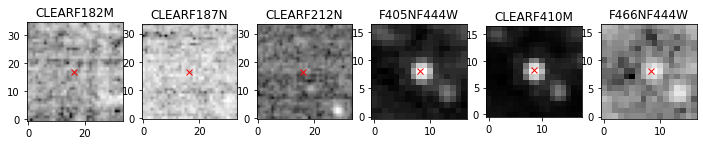

In [56]:
starzoom(coordinates.SkyCoord(266.54177, -28.74910, unit=(u.deg, u.deg), frame='icrs'))

/orange/adamginsburg/jwst/brick/F182M/pipeline/jw02221-o001_t001_nircam_clear-f182m-nrcb2_i2d.fits
/orange/adamginsburg/jwst/brick/F187N/pipeline/jw02221-o001_t001_nircam_clear-f187n-nrcb2_i2d.fits
/orange/adamginsburg/jwst/brick/F212N/pipeline/jw02221-o001_t001_nircam_clear-f212n-nrcb2_i2d.fits
/orange/adamginsburg/jwst/brick/F405N/pipeline/jw02221-o001_t001_nircam_clear-f405n-nrcb_i2d.fits
/orange/adamginsburg/jwst/brick/F410M/pipeline/jw02221-o001_t001_nircam_clear-f410m-nrcb_i2d.fits
/orange/adamginsburg/jwst/brick/F466N/pipeline/jw02221-o001_t001_nircam_clear-f466n-nrcb_i2d.fits


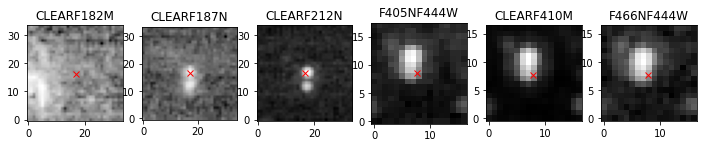

In [57]:
starzoom(coordinates.SkyCoord("17:46:10.006 -28:44:21.00", unit=(u.hour, u.deg), frame='icrs'))

/orange/adamginsburg/jwst/brick/F182M/pipeline/jw02221-o001_t001_nircam_clear-f182m-nrcb3_i2d.fits
/orange/adamginsburg/jwst/brick/F187N/pipeline/jw02221-o001_t001_nircam_clear-f187n-nrcb3_i2d.fits
/orange/adamginsburg/jwst/brick/F212N/pipeline/jw02221-o001_t001_nircam_clear-f212n-nrcb3_i2d.fits
/orange/adamginsburg/jwst/brick/F405N/pipeline/jw02221-o001_t001_nircam_clear-f405n-nrcb_i2d.fits
/orange/adamginsburg/jwst/brick/F410M/pipeline/jw02221-o001_t001_nircam_clear-f410m-nrcb_i2d.fits
/orange/adamginsburg/jwst/brick/F466N/pipeline/jw02221-o001_t001_nircam_clear-f466n-nrcb_i2d.fits


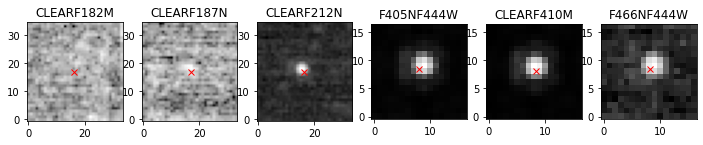

In [58]:
starzoom(coordinates.SkyCoord("17:46:10.682 -28:42:23.87", unit=(u.hour, u.deg), frame='icrs'))

/orange/adamginsburg/jwst/brick/F182M/pipeline/jw02221-o001_t001_nircam_clear-f182m-nrcb2_i2d.fits
/orange/adamginsburg/jwst/brick/F187N/pipeline/jw02221-o001_t001_nircam_clear-f187n-nrcb2_i2d.fits
/orange/adamginsburg/jwst/brick/F212N/pipeline/jw02221-o001_t001_nircam_clear-f212n-nrcb2_i2d.fits
/orange/adamginsburg/jwst/brick/F405N/pipeline/jw02221-o001_t001_nircam_clear-f405n-nrcb_i2d.fits
/orange/adamginsburg/jwst/brick/F410M/pipeline/jw02221-o001_t001_nircam_clear-f410m-nrcb_i2d.fits
/orange/adamginsburg/jwst/brick/F466N/pipeline/jw02221-o001_t001_nircam_clear-f466n-nrcb_i2d.fits


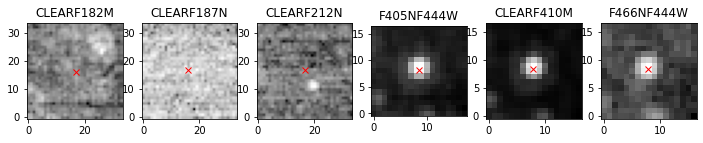

In [59]:
starzoom(coordinates.SkyCoord("17:46:09.310 -28:44:08.95", unit=(u.hour, u.deg), frame='icrs'))

/orange/adamginsburg/jwst/brick/F182M/pipeline/jw02221-o001_t001_nircam_clear-f182m-nrcb2_i2d.fits
/orange/adamginsburg/jwst/brick/F187N/pipeline/jw02221-o001_t001_nircam_clear-f187n-nrcb2_i2d.fits
/orange/adamginsburg/jwst/brick/F212N/pipeline/jw02221-o001_t001_nircam_clear-f212n-nrcb2_i2d.fits
/orange/adamginsburg/jwst/brick/F405N/pipeline/jw02221-o001_t001_nircam_clear-f405n-nrcb_i2d.fits
/orange/adamginsburg/jwst/brick/F410M/pipeline/jw02221-o001_t001_nircam_clear-f410m-nrcb_i2d.fits
/orange/adamginsburg/jwst/brick/F466N/pipeline/jw02221-o001_t001_nircam_clear-f466n-nrcb_i2d.fits


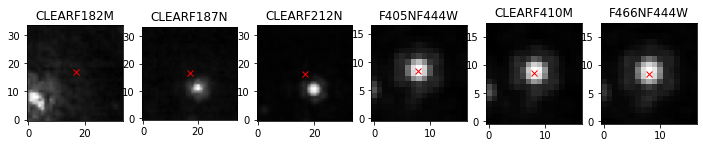

In [60]:
starzoom(coordinates.SkyCoord("17:46:09.256 -28:44:11.15", unit=(u.hour, u.deg), frame='icrs'))

/orange/adamginsburg/jwst/brick/F182M/pipeline/jw02221-o001_t001_nircam_clear-f182m-nrcb3_i2d.fits
/orange/adamginsburg/jwst/brick/F187N/pipeline/jw02221-o001_t001_nircam_clear-f187n-nrcb3_i2d.fits
/orange/adamginsburg/jwst/brick/F212N/pipeline/jw02221-o001_t001_nircam_clear-f212n-nrcb3_i2d.fits
/orange/adamginsburg/jwst/brick/F405N/pipeline/jw02221-o001_t001_nircam_clear-f405n-nrcb_i2d.fits
/orange/adamginsburg/jwst/brick/F410M/pipeline/jw02221-o001_t001_nircam_clear-f410m-nrcb_i2d.fits
/orange/adamginsburg/jwst/brick/F466N/pipeline/jw02221-o001_t001_nircam_clear-f466n-nrcb_i2d.fits


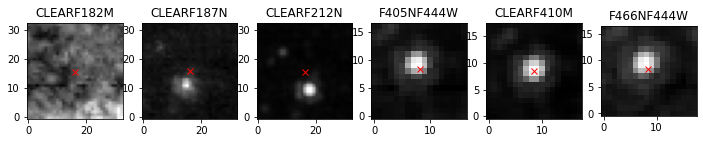

In [61]:
starzoom(coordinates.SkyCoord("17:46:03.833 -28:42:59.76", unit=(u.hour, u.deg), frame='icrs'))

/orange/adamginsburg/jwst/brick/F182M/pipeline/jw02221-o001_t001_nircam_clear-f182m-nrcb1-test_i2d.fits
/orange/adamginsburg/jwst/brick/F187N/pipeline/jw02221-o001_t001_nircam_clear-f187n-nrcb1_i2d.fits
/orange/adamginsburg/jwst/brick/F212N/pipeline/jw02221-o001_t001_nircam_clear-f212n-nrcb1_i2d.fits
/orange/adamginsburg/jwst/brick/F405N/pipeline/jw02221-o001_t001_nircam_clear-f405n-nrcb_i2d.fits
/orange/adamginsburg/jwst/brick/F410M/pipeline/jw02221-o001_t001_nircam_clear-f410m-nrcb_i2d.fits
/orange/adamginsburg/jwst/brick/F466N/pipeline/jw02221-o001_t001_nircam_clear-f466n-nrcb_i2d.fits


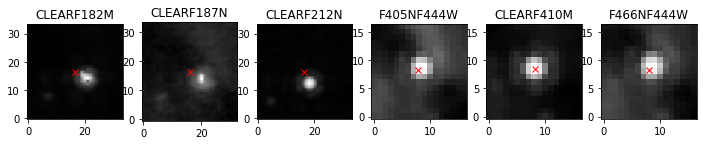

In [62]:
starzoom(coordinates.SkyCoord("17:46:07.378 -28:45:29.38", unit=(u.hour, u.deg), frame='icrs'))

In [63]:
ww410

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 266.5356189555997  -28.73734341061763  
CRPIX : 1439.274263177484  1145.788627232025  
PC1_1 PC1_2  : -0.01659228901693967  0.9998623384972445  
PC2_1 PC2_2  : 0.9998623384972445  0.01659228901693967  
CDELT : 1.74740511103546e-05  1.74740511103546e-05  
NAXIS : 2901  2297

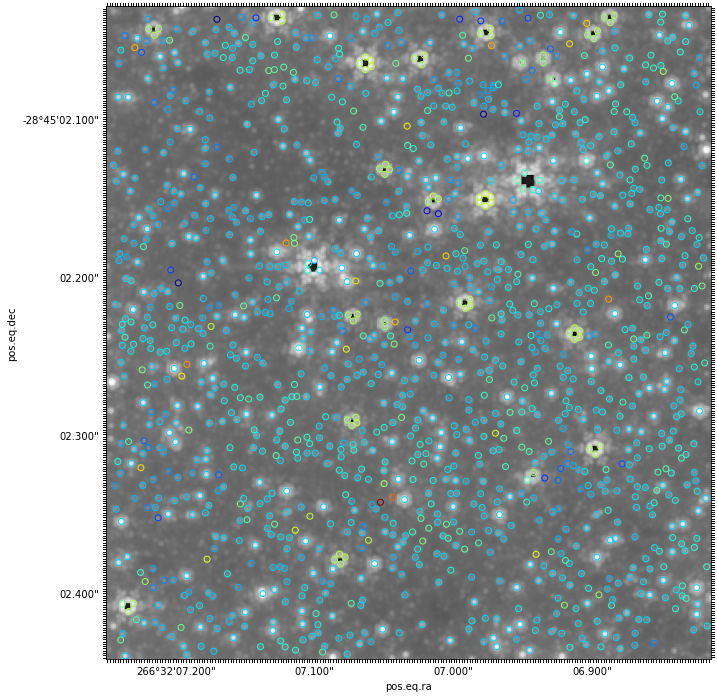

In [64]:
pl.figure(figsize=(12,12))
mask = reg.to_pixel(ww410).to_mask()
slcs,_ = mask.get_overlap_slices(fh['SCI'].data.shape)
ax = pl.subplot(projection=ww410[slcs])
co = mask.cutout(fh['SCI'].data)
co = fh['SCI'].data[slcs]
ax.imshow(co, cmap='gray', norm=simple_norm(co, stretch='log', max_percent=99.95), origin='lower')
crds = basetable['skycoords_f410m']
sel = reg.contains(crds, ww410)
xx,yy = ww410[slcs].world_to_pixel(crds[sel])

colorby = basetable['flux_f410m']
colorby = basetable['mag_ab_f410m'] - basetable['mag_ab_f405n']

scat = ax.scatter(crds.ra[sel], crds.dec[sel], transform=ax.get_transform('world'),
                  c=colorby[sel],
                  norm=simple_norm(colorby[sel], stretch='linear',), cmap='jet')
pl.draw()
colors = scat.get_facecolors()
scat.set_edgecolors(colors)
scat.set_facecolors('none')

lon = ax.coords[0]
lat = ax.coords[1]
lon.set_major_formatter('dd:mm:ss.sss')
lat.set_major_formatter('dd:mm:ss.sss')
lon.set_ticks(spacing=0.1 * u.arcsec)
lat.set_ticks(spacing=0.1 * u.arcsec)

In [65]:
tbls[0].meta

OrderedDict([('filename',
              '/orange/adamginsburg/jwst/brick//F410M/f410m_nrcb_crowdsource.fits'),
             ('filter', 'f410m'),
             ('pixelscale', <Quantity 3.05342462e-10 deg2>)])

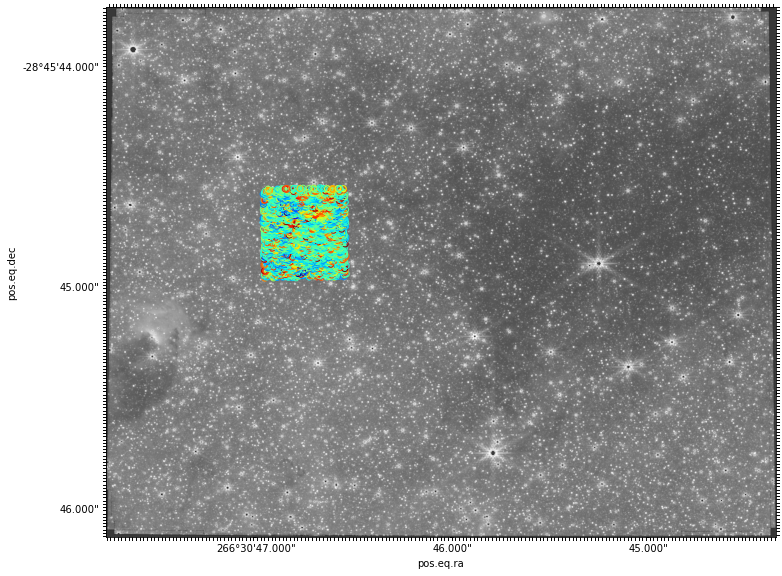

In [66]:
pl.figure(figsize=(12,12))
mask = reg.to_pixel(ww410).to_mask()
slcs,_ = mask.get_overlap_slices(fh['SCI'].data.shape)
ax = pl.subplot(projection=ww410)
#ax = pl.gca()
co = fh['SCI'].data
ax.imshow(co, cmap='gray', norm=simple_norm(co, stretch='log', max_percent=99.95), origin='lower')
crds = basetable['skycoords_f410m']
#crds = tbls[0]['skycoords']
sel = reg.contains(crds, ww410)
xx,yy = ww410[slcs].world_to_pixel(crds[sel])
#scat = ax.scatter(xx, yy, c=basetable['flux_f410m'][sel],
#                  norm=simple_norm(basetable['flux_f410m'][sel], stretch='log',), cmap='jet')
scat = ax.scatter(crds.ra[sel], crds.dec[sel], transform=ax.get_transform('world'), c=basetable['flux_f410m'][sel],
           norm=simple_norm(basetable['flux_f410m'][sel], stretch='log',), cmap='jet')
pl.draw()
colors = scat.get_facecolors()
scat.set_edgecolors(colors)
scat.set_facecolors('none')

lon = ax.coords[0]
lat = ax.coords[1]
lon.set_major_formatter('dd:mm:ss.sss')
lat.set_major_formatter('dd:mm:ss.sss')
lon.set_ticks(spacing=1 * u.arcsec)
lat.set_ticks(spacing=1 * u.arcsec)

(676.0, 1043.0, 1119.0, 1515.0)

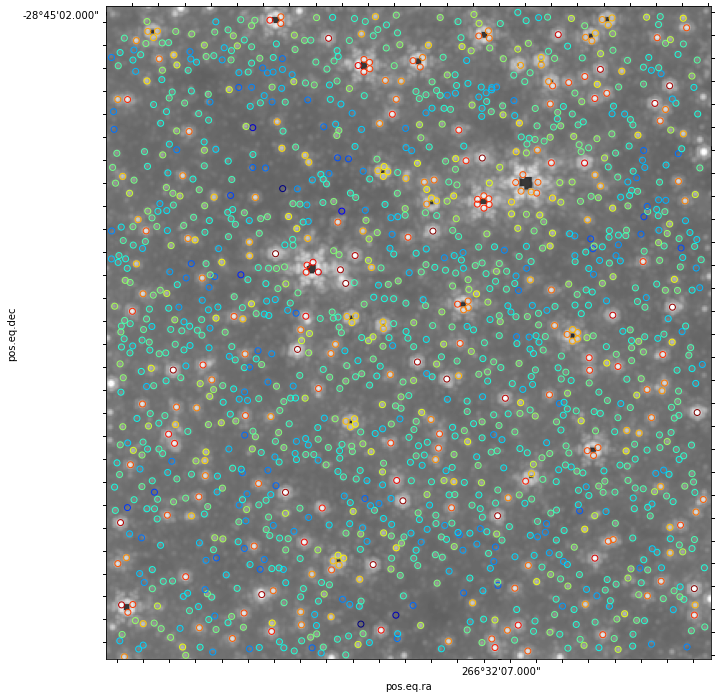

In [67]:
pl.figure(figsize=(12,12))
mask = reg.to_pixel(ww410).to_mask()
slcs,_ = mask.get_overlap_slices(fh['SCI'].data.shape)
ax = pl.subplot(projection=ww410)
#ax = pl.gca()
co = fh['SCI'].data
ax.imshow(co, cmap='gray', norm=simple_norm(co, stretch='log', max_percent=99.95), origin='lower')
crds = basetable['skycoords_f410m']
#crds = tbls[0]['skycoords']
sel = reg.contains(crds, ww410)
xx,yy = ww410[slcs].world_to_pixel(crds[sel])
#scat = ax.scatter(xx, yy, c=basetable['flux_f410m'][sel],
#                  norm=simple_norm(basetable['flux_f410m'][sel], stretch='log',), cmap='jet')
scat = ax.scatter(crds.ra[sel], crds.dec[sel], transform=ax.get_transform('world'), c=basetable['flux_f410m'][sel],
           norm=simple_norm(basetable['flux_f410m'][sel], stretch='log',), cmap='jet')
pl.draw()
colors = scat.get_facecolors()
scat.set_edgecolors(colors)
scat.set_facecolors('none')

lon = ax.coords[0]
lat = ax.coords[1]
lon.set_major_formatter('dd:mm:ss.sss')
lat.set_major_formatter('dd:mm:ss.sss')
lon.set_ticks(spacing=1 * u.arcsec)
lat.set_ticks(spacing=1 * u.arcsec)
ax.axis((676,1043,1119,1515))

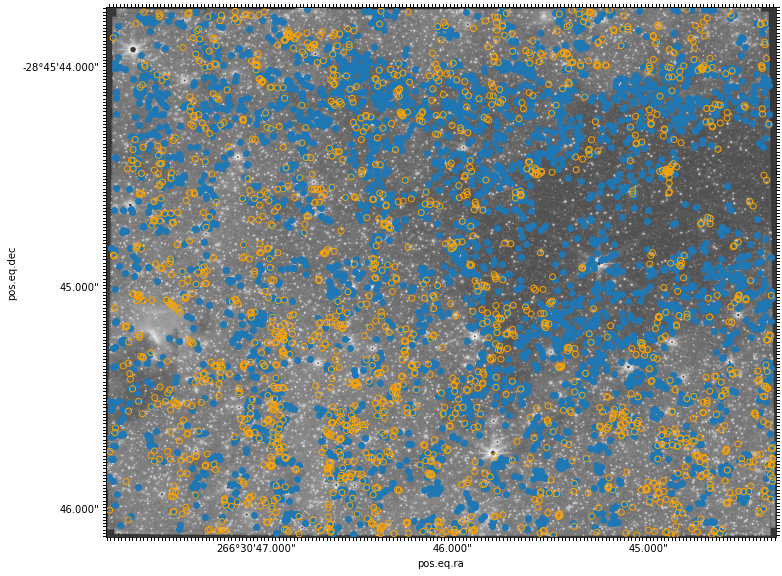

In [68]:
pl.figure(figsize=(12,12))
mask = reg.to_pixel(ww410).to_mask()
slcs,_ = mask.get_overlap_slices(fh['SCI'].data.shape)
ax = pl.subplot(projection=ww410)
#ax = pl.gca()
co = fh['SCI'].data
ax.imshow(co, cmap='gray', norm=simple_norm(co, stretch='log', max_percent=99.95), origin='lower')
crds = basetable['skycoords_f410m']
#crds = tbls[0]['skycoords']
sel = reg.contains(crds, ww410)
xx,yy = ww410[slcs].world_to_pixel(crds[sel])
##scat = ax.scatter(xx, yy, c=basetable['flux_f410m'][sel],
##                  norm=simple_norm(basetable['flux_f410m'][sel], stretch='log',), cmap='jet')
#scat = ax.scatter(crds.ra[sel], crds.dec[sel], transform=ax.get_transform('world'), c=basetable['flux_f410m'][sel],
#           norm=simple_norm(basetable['flux_f410m'][sel], stretch='log',), cmap='jet')
#pl.draw()
#colors = scat.get_facecolors()
#scat.set_edgecolors(colors)
#scat.set_facecolors('none')

blue_410_466 = (basetable['mag_ab_f410m'] - basetable['mag_ab_f466n']) < -1.25
pl.scatter(crds.ra[blue_410_466], crds.dec[blue_410_466], transform=ax.get_transform('world'))
blue_410_405 = (basetable['mag_ab_f410m'] - basetable['mag_ab_f405n']) < -1.00
pl.scatter(crds.ra[blue_410_405], crds.dec[blue_410_405], edgecolors='orange', facecolors='none', transform=ax.get_transform('world'))

lon = ax.coords[0]
lat = ax.coords[1]
lon.set_major_formatter('dd:mm:ss.sss')
lat.set_major_formatter('dd:mm:ss.sss')
lon.set_ticks(spacing=1 * u.arcsec)
lat.set_ticks(spacing=1 * u.arcsec)

Set DATE-AVG to '2022-08-28T03:05:31.909' from MJD-AVG.
Set DATE-END to '2022-08-28T03:34:03.557' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -20.633936 from OBSGEO-[XYZ].
Set OBSGEO-H to 1526083300.815 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


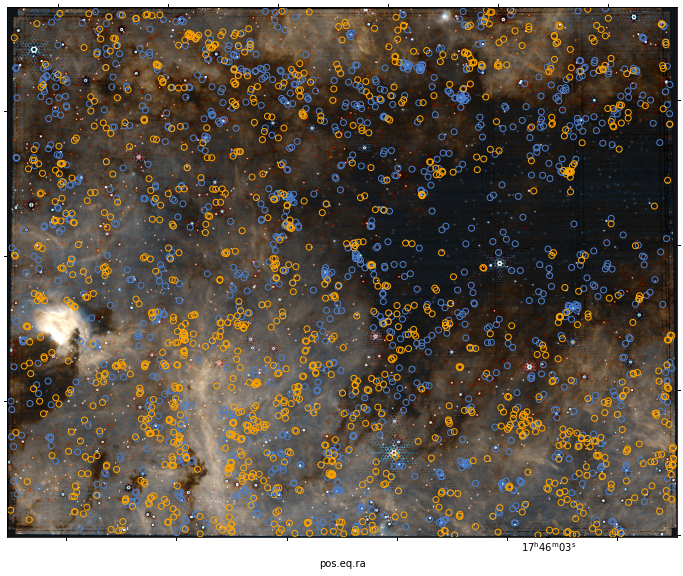

In [95]:
# This image shows only H-alpha stars
avm = pyavm.AVM.from_image(f'{basepath}/images/BrickJWST_nrcb_longwave_narrowband_rotated_lighter.png')
img_narrow = np.array(PIL.Image.open(f'{basepath}/images/BrickJWST_nrcb_longwave_narrowband_rotated_lighter.png'))[::-1,:,:]
#wwi_bra_410 = avm.to_wcs(use_full_header=True)
wwi_narrow = wcs.WCS(fits.Header.fromstring(avm.Spatial.FITSheader))


pl.figure(figsize=(12,12))
ax = pl.subplot(projection=wwi_narrow)
ax.imshow(img_narrow)

crds = basetable['skycoords_f410m']
blue_410_466 = (basetable['mag_ab_410m405'] - basetable['mag_ab_f466n']) < -1.75
ax.scatter(crds.ra[blue_410_466], crds.dec[blue_410_466], transform=ax.get_transform('world'), edgecolors=(0.3, 0.5, 0.8), facecolors='none')
blue_410_405 = (basetable['mag_ab_410m405'] - basetable['mag_ab_f405n']) < -1.25
ax.scatter(crds.ra[blue_410_405], crds.dec[blue_410_405], edgecolors='orange', facecolors='none', transform=ax.get_transform('world'))



(25.0, 14.0)

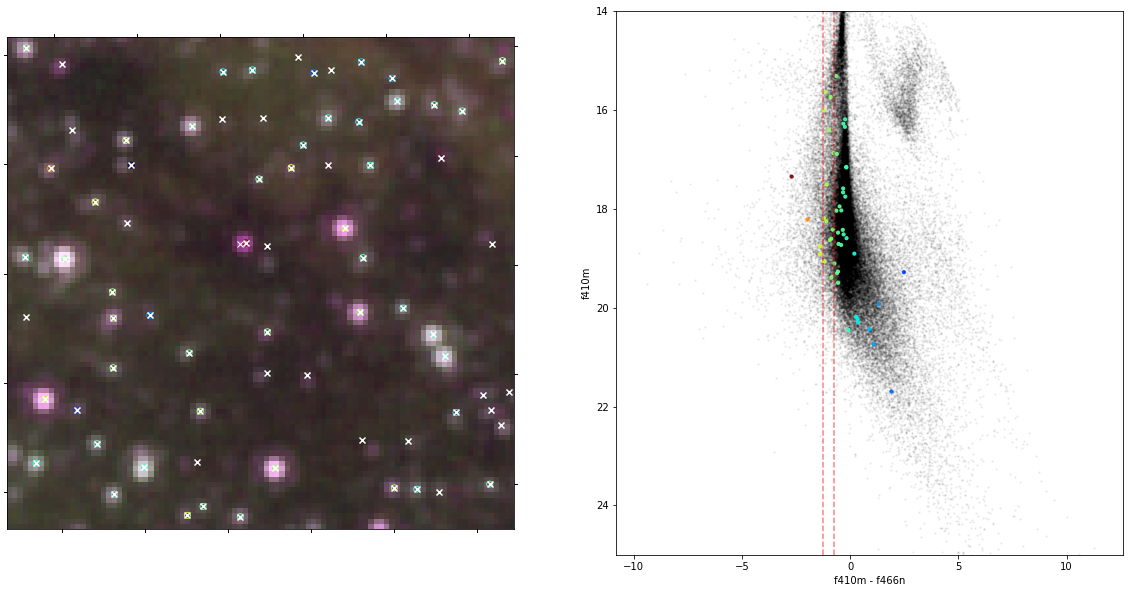

In [80]:
mask = regzoom.to_pixel(wwi).to_mask()
slcs,_ = mask.get_overlap_slices(img.shape[:2])
#co = np.array([mask.cutout(img[:,:,ii]) for ii in range(img.shape[2])])
co = img[slcs[0], slcs[1], :]

pl.figure(figsize=(20,10))
ax = pl.subplot(1,2,1, projection=wwi[slcs])
pl.imshow(co)

crds = basetable['skycoords_f410m']
sel = regzoom.contains(crds, ww410)
sel &= basetable['sep_f405n'].quantity < 0.1*u.arcsec
xx,yy = ww410[slcs].world_to_pixel(crds[sel])

colorby = basetable['flux_f410m']
colorby = basetable['mag_ab_f410m'] - basetable['mag_ab_f405n']
colorby = basetable['mag_ab_f410m'] - basetable['mag_ab_f466n']
#sel = sel & (colorby < -2)

scat = ax.scatter(crds.ra[sel], crds.dec[sel], transform=ax.get_transform('world'),
                  #edgecolor='r', facecolor='none', marker='s')#r'$\rightarrow$')
                  c=colorby[sel],
                  norm=simple_norm(colorby[sel], stretch='asinh',), cmap='jet_r')
pl.draw()
colors = scat.get_facecolors()
scat.set_edgecolors(colors)
scat.set_facecolors('none')
#pl.colorbar(mappable=scat)
axlims = ax.axis()
pl.plot(44,54, 'wx')
wwi[slcs].pixel_to_world(45,55)

# show the maximum detections
sel2 = regzoom.contains(tbls[0]['skycoords'], ww410)
ax.scatter(tbls[0]['skycoords'].ra[sel2], tbls[0]['skycoords'].dec[sel2], marker='x', color='w', transform=ax.get_transform('world'))
ax.axis(axlims)

ax2 = pl.subplot(1,2,2)
ax2.scatter(basetable['mag_ab_f410m'] - basetable['mag_ab_f466n'], basetable['mag_ab_f410m'], s=2, alpha=0.05, c='k')
ax2.scatter((basetable['mag_ab_f410m'] - basetable['mag_ab_f466n'])[sel], basetable['mag_ab_f410m'][sel], s=10, alpha=0.9,
            c=colorby[sel],
            norm=simple_norm(colorby[sel], stretch='asinh',), cmap='jet_r'
           )
ax2.axvline(-0.75, linestyle='--', color='r', alpha=0.5)
ax2.axvline(-1.25, linestyle='--', color='r', alpha=0.5)
ax2.set_ylim(pl.ylim()[::-1])
ax2.set_xlabel("f410m - f466n")
ax2.set_ylabel("f410m")
ax2.set_ylim(25,14)

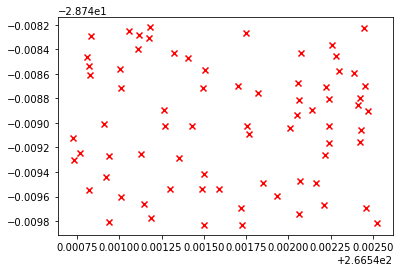

In [78]:
pl.scatter(tbls[0]['skycoords'].ra[sel2], tbls[0]['skycoords'].dec[sel2], marker='x', color='r')